In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

pd.set_option('display.max_columns', None)

## 1. Question 3: 

**Q3 : Can we predict price with some of the basic features? (Not more that 10 distinct features, maybe??)**

In [2]:
seattle_listings = pd.read_csv('data/seattle/listings.csv')
seattle_listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2318,https://www.airbnb.com/rooms/2318,20200521035945,2020-05-21,Casa Madrona - Urban Oasis 1 block from the park!,"Gorgeous, architect remodeled, Dutch Colonial ...","This beautiful, gracious home has been complet...","Gorgeous, architect remodeled, Dutch Colonial ...",none,Madrona is a hidden gem of a neighborhood. It ...,"We adhere to a 10pm -9am quiet hour schedule, ...",NaN,Guests can access any part of the house.,We are a family who live next door and are ava...,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/02973ad3-a...,NaN,2536,https://www.airbnb.com/users/show/2536,Megan,2008-08-26,"Seattle, Washington, United States",I welcome guests from all walks of life and ev...,within a few hours,67%,88%,t,https://a0.muscache.com/im/pictures/user/016a1...,https://a0.muscache.com/im/pictures/user/016a1...,Minor,2,2,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"Seattle, WA, United States",Madrona,Madrona,Central Area,Seattle,WA,98122,Seattle,"Seattle, WA",US,United States,47.61082,-122.29082,t,House,Entire home/apt,9,2.5,4.0,4.0,Real Bed,"{Internet,Wifi,Kitchen,""Free parking on premis...",NaN,$296.00,NaN,NaN,$500.00,$250.00,8,$25.00,1,1125,1,1,1125,1125,1.0,1125.0,today,t,29,59,89,132,2020-05-21,32,7,2008-09-15,2020-02-01,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,STR-OPLI-19-002837,"{WASHINGTON,"" Seattle"","" WA""}",t,f,strict_14_with_grace_period,f,f,2,2,0,0,0.22
1,6606,https://www.airbnb.com/rooms/6606,20200521035945,2020-05-21,"Fab, private seattle urban cottage!","This tiny cottage is only 15x10, but it has ev...","Soo centrally located, this is a little house ...","This tiny cottage is only 15x10, but it has ev...",none,"A peaceful yet highly accessible neighborhood,...","Check in is at three, if you'd like a snack or...",NaN,NaN,I often escape to kingston and my place on the...,Please treat the cottage as if it were your ow...,NaN,NaN,https://a0.muscache.com/im/pictures/45742/2111...,NaN,14942,https://www.airbnb.com/users/show/14942,Joyce,2009-04-26,"Seattle, Washington, United States",I am a therapist/innkeeper.I know my city well...,within an hour,100%,92%,f,https://a0.muscache.com/im/users/14942/profile...,https://a0.muscache.com/im/users/14942/profile...,Wallingford,5,5,"['email', 'phone', 'facebook', 're

### 1.1. Price Column Cleaning and Outlier Cleaning:

**Before we start, we should drop the outlier priced houses**

In [3]:
seattle_listings['price'] = seattle_listings['price'].map(lambda x: int(x[1:-3].replace(",", "")))

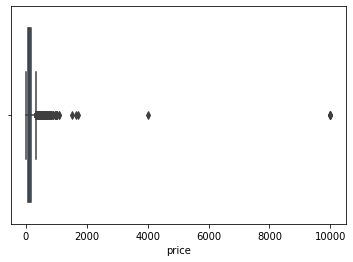

In [4]:
sns.boxplot(x='price', data=seattle_listings)

As you can see, I multiplied IQR with 3 to not eliminate many outliers. (As I know status quo says that, > IQR * 1.5 + 3rd QR gives outliers; but I multiplied with 3 to not eliminate many data points)

In [5]:
first_quartile = seattle_listings['price'].quantile(0.25)
third_quartile = seattle_listings['price'].quantile(0.75)
threshold_upper = 3 * (third_quartile - first_quartile) + third_quartile
threshold_upper

483.0

In [6]:
seattle_listings = seattle_listings.loc[seattle_listings['price'] <= threshold_upper, :]

In [7]:
X = seattle_listings[['host_response_time', 'host_response_rate', 'neighbourhood_group_cleansed', 'property_type', 'bathrooms',
                      'bedrooms', 'beds', 'square_feet', 'number_of_reviews', 'review_scores_rating']]
y = seattle_listings['price']

In [8]:
X.rename(columns= lambda s: s.replace('"', '').strip().capitalize(), inplace=True)

C:\Users\Tahsin\Anaconda3\envs\py36\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
X.head()

,Host_response_time,Host_response_rate,Neighbourhood_group_cleansed,Property_type,Bathrooms,Bedrooms,Beds,Square_feet,Number_of_reviews,Review_scores_rating
0,within a few hours,67%,Central Area,House,2.5,4.0,4.0,NaN,32,100.0
1,within an hour,100%,Other neighborhoods,Guesthouse,1.0,1.0,1.0,NaN,150,92.0
2,within a few hours,90%,Other neighborhoods,Apartment,3.0,1.0,1.0,200.0,148,93.0
3,within an hour,100%,West Seattle,House,1.0,2.0,3.0,1200.0,40,100.0
4,within an hour,100%,West Seattle,Guest suite,1.0,2.0,2.0,NaN,50,100.0


### 1.2. Splitting the dataset into the Training set and Test set 

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5432, 10), (5432,), (1359, 10), (1359,))

### 1.3. Taking Care Of Missing Data 

In [12]:
X_train.isna().sum() / X_train.shape[0]

Host_response_time              0.252209
Host_response_rate              0.252209
Neighbourhood_group_cleansed    0.000000
Property_type                   0.000000
Bathrooms                       0.000000
Bedrooms                        0.000552
Beds                            0.010125
Square_feet                     0.965943
Number_of_reviews               0.000000
Review_scores_rating            0.138623
dtype: float64

In [13]:
X_train.drop("Square_feet", axis=1, inplace=True)
X_test.drop("Square_feet", axis=1, inplace=True)

C:\Users\Tahsin\Anaconda3\envs\py36\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [14]:
X_train.loc[:, X_train.isna().any()]

,Host_response_time,Host_response_rate,Bedrooms,Beds,Review_scores_rating
3764,NaN,NaN,2.0,2.0,89.0
3542,NaN,NaN,1.0,2.0,96.0
6168,within an hour,100%,2.0,2.0,96.0
634,within an hour,100%,1.0,1.0,95.0
4712,within an hour,100%,1.0,1.0,100.0
...,...,...,...,...,...
5065,within an hour,100%,1.0,1.0,NaN
3356,NaN,NaN,2.0,2.0,NaN
1693,NaN,NaN,1.0,1.0,93.0
2676,NaN,NaN,2.0,2.0,89.0


In [15]:
X_test.loc[:, X_test.isna().any()]

,Host_response_time,Host_response_rate,Bedrooms,Beds,Review_scores_rating
4707,NaN,NaN,0.0,1.0,80.0
2058,NaN,NaN,1.0,1.0,99.0
3602,NaN,NaN,2.0,2.0,94.0
2291,within an hour,100%,0.0,1.0,90.0
6182,within an hour,100%,2.0,3.0,100.0
...,...,...,...,...,...
3144,NaN,NaN,1.0,1.0,90.0
89,within a few hours,100%,1.0,1.0,94.0
4629,NaN,NaN,1.0,2.0,NaN
1828,NaN,NaN,3.0,4.0,96.0


In [16]:
y_train.isna().any()

False

In [17]:
y_test.isna().any()

False

In [18]:
X_train.loc[:, 'Host_response_time'] = X_train.loc[:, 'Host_response_time'].fillna(X_train['Host_response_time'].mode()[0])
X_train.loc[:, 'Host_response_rate'] = X_train.loc[:, 'Host_response_rate'].fillna(X_train['Host_response_rate'].mode()[0])

C:\Users\Tahsin\Anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [19]:
X_test.loc[:, 'Host_response_time'] = X_test.loc[:, 'Host_response_time'].fillna(X_train['Host_response_time'].mode()[0])
X_test.loc[:, 'Host_response_rate'] = X_test.loc[:, 'Host_response_rate'].fillna(X_train['Host_response_rate'].mode()[0])

In [20]:
X_train.loc[:, 'Bedrooms'] = X_train.loc[:, 'Bedrooms'].fillna(X_train['Bedrooms'].mean())
X_train.loc[:, 'Beds'] = X_train.loc[:, 'Beds'].fillna(X_train['Beds'].mean())
X_train.loc[:, 'Review_scores_rating'] = X_train.loc[:, 'Review_scores_rating'].fillna(X_train['Review_scores_rating'].mean())

In [21]:
X_test.loc[:, 'Bedrooms'] = X_test.loc[:, 'Bedrooms'].fillna(X_train['Bedrooms'].mean())
X_test.loc[:, 'Beds'] = X_test.loc[:, 'Beds'].fillna(X_train['Beds'].mean())
X_test.loc[:, 'Review_scores_rating'] = X_test.loc[:, 'Review_scores_rating'].fillna(X_train['Review_scores_rating'].mean())
X_test.loc[:, 'Bathrooms'] = X_test.loc[:, 'Bathrooms'].fillna(X_train['Bathrooms'].mean())

### 1.3. Encoding categorical data 

In [22]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), [0, 1, 2, 3])], remainder='passthrough')
X_train = ct.fit_transform(X_train).toarray()
X_test = ct.transform(X_test).toarray()

### 1.4. Let's Train And Predict The Model

In [39]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'linear')
regressor.fit(X_train, y_train)

SVR(kernel='linear')

In [40]:
y_pred = regressor.predict(X_test)
y_pred_train = regressor.predict(X_train)

In [41]:
rsquared_svr_model_train = r2_score(y_train, y_pred_train)
rsquared_svr_model = r2_score(y_test, y_pred)
rmse_svr_model = np.sqrt(mean_squared_error(y_test, y_pred))

print("We miss the price by the average of ${0}".format(rmse_svr_model))
print("R-squared value is = {0} for train".format(rsquared_svr_model_train))
print("R-squared value is = {0} for test".format(rsquared_svr_model))

We miss the price by the average of $57.123838412997046
R-squared value is = 0.44020439213105367 for train
R-squared value is = 0.4904218557352209 for test


In [43]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 50, random_state = 21)
regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=21)

In [44]:
y_pred = regressor.predict(X_test)
y_pred_train = regressor.predict(X_train)

In [45]:
rsquared_rf_model_train = r2_score(y_train, y_pred_train)
rsquared_rf_model = r2_score(y_test, y_pred)
rmse_rf_model = np.sqrt(mean_squared_error(y_test, y_pred))

print("We miss the price by the average of ${0}".format(rmse_rf_model))
print("R-squared value is = {0} for train".format(rsquared_rf_model_train))
print("R-squared value is = {0} for test".format(rsquared_rf_model))

We miss the price by the average of $54.596142709452046
R-squared value is = 0.9185667307381273 for train
R-squared value is = 0.534521153396055 for test


In [46]:
from sklearn.ensemble import GradientBoostingRegressor
regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

GradientBoostingRegressor()

In [47]:
y_pred = regressor.predict(X_test)
y_pred_train = regressor.predict(X_train)

In [48]:
rsquared_gbr_model_train = r2_score(y_train, y_pred_train)
rsquared_gbr_model = r2_score(y_test, y_pred)
rmse_gbr_model = np.sqrt(mean_squared_error(y_test, y_pred))

print("We miss the price by the average of ${0}".format(rmse_gbr_model))
print("R-squared value is = {0} for train".format(rsquared_gbr_model_train))
print("R-squared value is = {0} for test".format(rsquared_gbr_model))

We miss the price by the average of $52.62726263249674
R-squared value is = 0.5900311024368246 for train
R-squared value is = 0.5674885679549404 for test


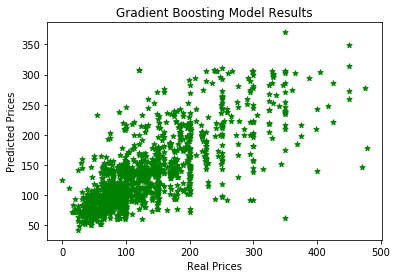

In [52]:
plt.scatter(y_test, y_pred, color= "green", marker= "*", s=30) 

# x-axis label 
plt.xlabel('Real Prices') 
# y-axis label 
plt.ylabel('Predicted Prices') 
# plot title 
plt.title('Gradient Boosting Model Results')

plt.savefig('GBR.png')

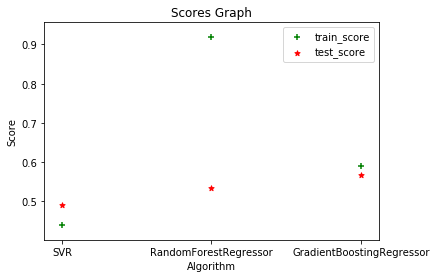

In [50]:
train_scores = [rsquared_svr_model_train, rsquared_rf_model_train, rsquared_gbr_model_train]
test_scores = [rsquared_svr_model, rsquared_rf_model, rsquared_gbr_model]
labels = ['SVR', 'RandomForestRegressor', 'GradientBoostingRegressor']

# plotting points as a scatter plot 
plt.scatter(labels, train_scores, color= "green", marker= "+", s=30) 
plt.scatter(labels, test_scores, color= "red", marker= "*", s=30) 
# x-axis label 
plt.xlabel('Algorithm') 
# y-axis label 
plt.ylabel('Score') 
# plot title 
plt.title('Scores Graph') 
# showing legend 
plt.legend(['train_score', 'test_score']) 

plt.savefig('Algorithm Comparison.png')

Our models really fail to explain prices for different independent variables. Forecasts are independent from the reality. We should look for every variable by self and then try to decrease the error by adding new variables. However, with these variables we cannot explain the variability.

Even though the models don't look very promising, it is a very good start for us.

As you can see boosting perform better! Because of less data and much more independent variables, overfitting is inevitable for complex algorithms such as random forest. But boosting covers up for this problem much better! 